In [2]:
from formulas import *
import math
from sklearn import preprocessing, svm #scale, regresions, cross shuffle stats sepeareate data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_iris 
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [4]:
df = yf.Ticker('MSFT').history(period="max").reset_index()
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-03-13 00:00:00-05:00,0.055004,0.063093,0.055004,0.060396,1031788800,0.0,0.0
1,1986-03-14 00:00:00-05:00,0.060396,0.063632,0.060396,0.062553,308160000,0.0,0.0
2,1986-03-17 00:00:00-05:00,0.062553,0.064172,0.062553,0.063632,133171200,0.0,0.0
3,1986-03-18 00:00:00-05:00,0.063632,0.064172,0.061475,0.062014,67766400,0.0,0.0
4,1986-03-19 00:00:00-05:00,0.062014,0.062553,0.060396,0.060936,47894400,0.0,0.0
...,...,...,...,...,...,...,...,...
9484,2023-10-30 00:00:00-04:00,333.410004,339.450012,331.829987,337.309998,22828100,0.0,0.0
9485,2023-10-31 00:00:00-04:00,338.850006,339.000000,334.690002,338.109985,20265300,0.0,0.0
9486,2023-11-01 00:00:00-04:00,339.790009,347.420013,339.649994,346.070007,28158800,0.0,0.0
9487,2023-11-02 00:00:00-04:00,347.239990,348.829987,344.769989,348.320007,24348100,0.0,0.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

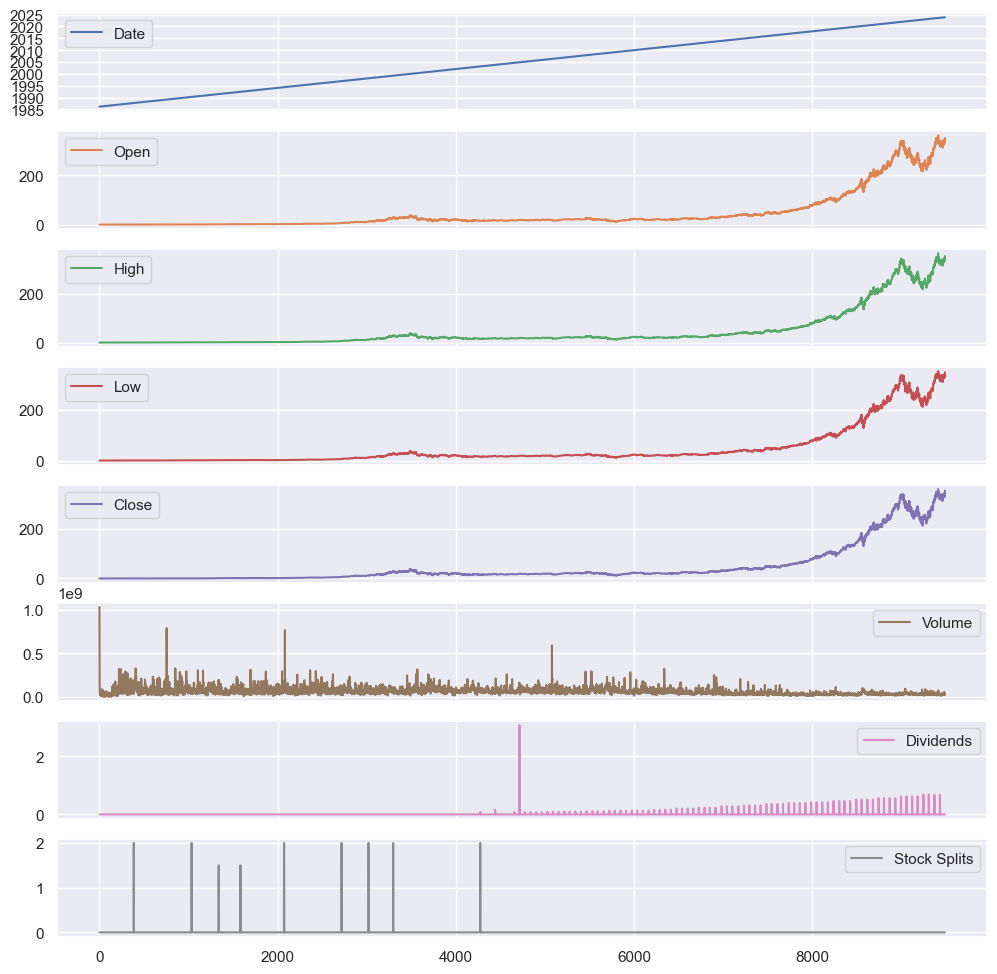

In [5]:
df.plot(kind="line",figsize=(12,12),subplots=True)

In [6]:
df.shape

(9489, 8)

In [7]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6999


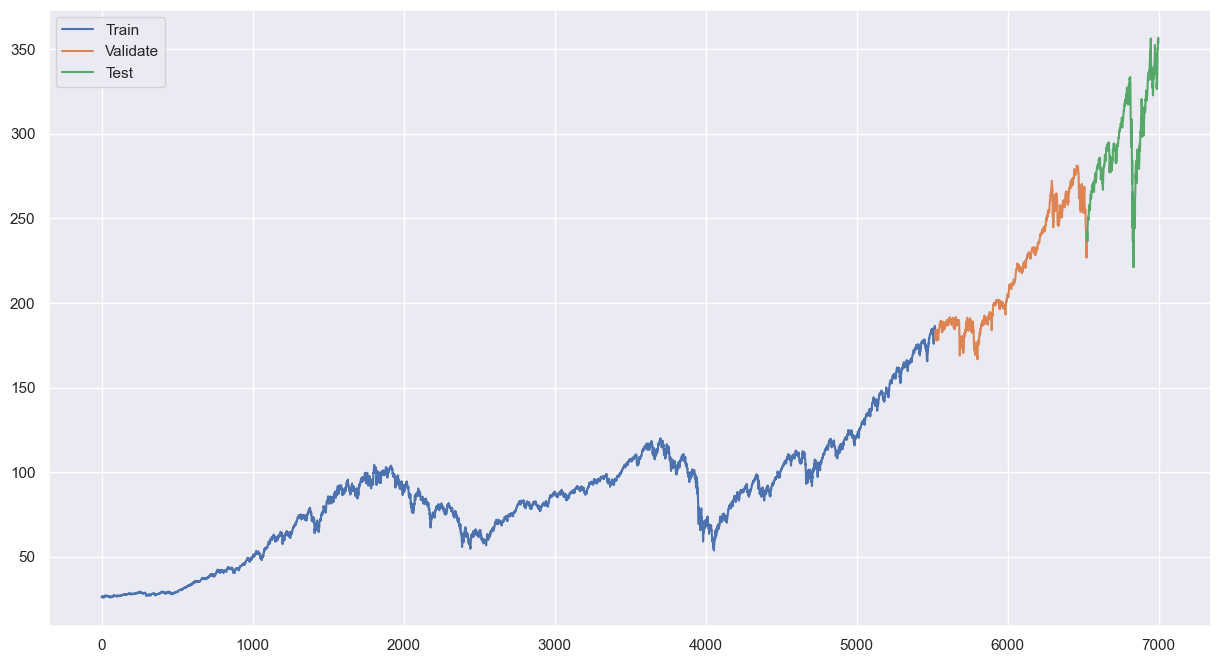

In [8]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [9]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [10]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [11]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
276/276 [==============================] - 21s 23ms/step - loss: 0.0084 - mae: 0.1023 - lr: 1.0000e-05
Epoch 2/100
276/276 [==============================] - 5s 20ms/step - loss: 6.5692e-04 - mae: 0.0260 - lr: 1.1220e-05
Epoch 3/100
276/276 [==============================] - 6s 20ms/step - loss: 4.2020e-04 - mae: 0.0213 - lr: 1.2589e-05
Epoch 4/100
276/276 [==============================] - 9s 31ms/step - loss: 2.8403e-04 - mae: 0.0181 - lr: 1.4125e-05
Epoch 5/100
276/276 [==============================] - 8s 30ms/step - loss: 2.0603e-04 - mae: 0.0158 - lr: 1.5849e-05
Epoch 6/100
276/276 [==============================] - 7s 25ms/step - loss: 1.6459e-04 - mae: 0.0143 - lr: 1.7783e-05
Epoch 7/100
276/276 [==============================] - 6s 23ms/step - loss: 1.4319e-04 - mae: 0.0133 - lr: 1.9953e-05
Epoch 8/100
276/276 [==============================] - 6s 22ms/step - loss: 1.3130e-04 - mae: 0.0126 - lr: 2.2387e-05
Epoch 9/100
276/276 [==============================] - 6s 2

(1e-08, 1.0, 0.0, 0.01)

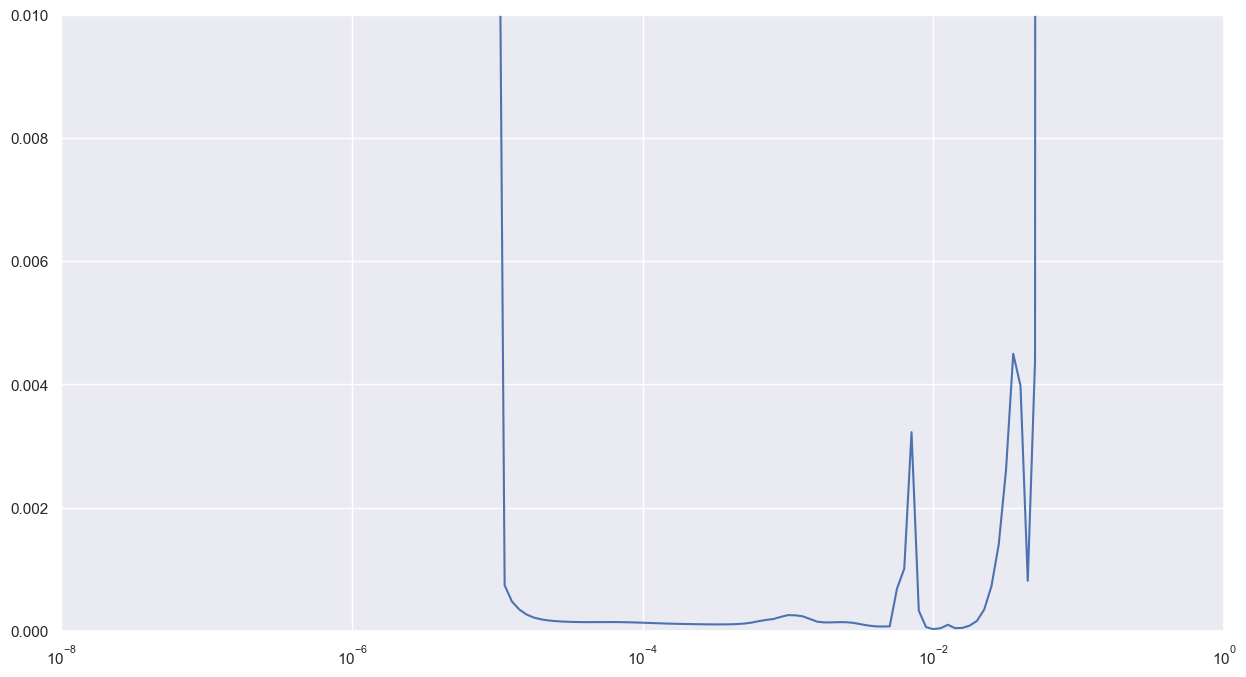

In [45]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

## Build and Train LSTM Model

In [54]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=200,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/200
184/184 [==============================] - 12s 37ms/step - loss: 2.5960e-04 - mae: 0.0159 - val_loss: 0.0077 - val_mae: 0.0911
Epoch 2/200
184/184 [==============================] - 3s 19ms/step - loss: 8.7591e-04 - mae: 0.0246 - val_loss: 0.0054 - val_mae: 0.0774
Epoch 3/200
184/184 [==============================] - 5s 25ms/step - loss: 8.9412e-04 - mae: 0.0249 - val_loss: 0.0040 - val_mae: 0.0656
Epoch 4/200
184/184 [==============================] - 5s 29ms/step - loss: 6.9411e-04 - mae: 0.0219 - val_loss: 0.0017 - val_mae: 0.0434
Epoch 5/200
184/184 [==============================] - 6s 32ms/step - loss: 3.7025e-04 - mae: 0.0160 - val_loss: 6.0851e-04 - val_mae: 0.0274
Epoch 6/200
184/184 [==============================] - 5s 30ms/step - loss: 1.7724e-04 - mae: 0.0118 - val_loss: 6.4707e-04 - val_mae: 0.0308
Epoch 7/200
184/184 [==============================] - 5s 27ms/step - loss: 1.0344e-04 - mae: 0.0099 - val_loss: 7.5038e-04 - val_mae: 0.0321
Epoch 8/200
184/184 [

Epoch 59/200
184/184 [==============================] - 6s 32ms/step - loss: 3.0343e-05 - mae: 0.0052 - val_loss: 1.5069e-04 - val_mae: 0.0137
Epoch 60/200
184/184 [==============================] - 6s 31ms/step - loss: 2.7377e-05 - mae: 0.0051 - val_loss: 9.5673e-05 - val_mae: 0.0103
Epoch 61/200
184/184 [==============================] - 5s 30ms/step - loss: 4.1412e-05 - mae: 0.0056 - val_loss: 0.0035 - val_mae: 0.0821
Epoch 62/200
184/184 [==============================] - 5s 29ms/step - loss: 7.6550e-05 - mae: 0.0089 - val_loss: 0.0024 - val_mae: 0.0680
Epoch 63/200
184/184 [==============================] - 6s 31ms/step - loss: 1.2250e-04 - mae: 0.0111 - val_loss: 5.8075e-04 - val_mae: 0.0255
Epoch 64/200
184/184 [==============================] - 5s 25ms/step - loss: 8.7675e-05 - mae: 0.0065 - val_loss: 2.1150e-04 - val_mae: 0.0162
Epoch 65/200
184/184 [==============================] - 4s 19ms/step - loss: 2.2222e-05 - mae: 0.0046 - val_loss: 1.9549e-04 - val_mae: 0.0149
Epoch 6

In [12]:
# recall best model
model = keras.models.load_model("my_checkpoint1.h5")

## Make Predictions

In [13]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()

1/1 [==============================] - 2s 2s/step


In [14]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(472,)

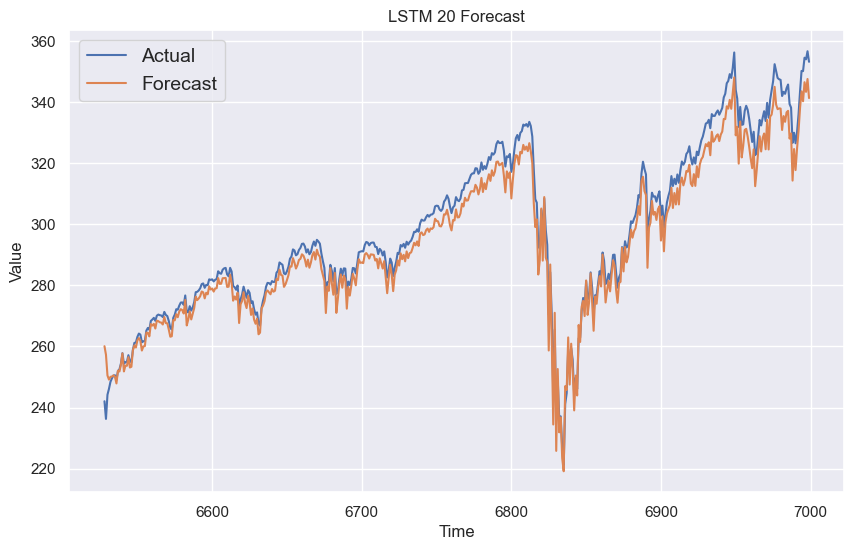

In [15]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [16]:
# calculate MAE
lstm_mea=keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()
lstm_mea

4.629928

In [17]:
# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(x_test, rnn_unscaled_forecast))
print(f"Root Mean Square Error (RMSE): {lstm_rmse}")

Root Mean Square Error (RMSE): 5.390152218444839


### Streamlit Link1: http://localhost:8501/